In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import warnings
import pandas as pd
from yfinance import download
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = 14, 6

warnings.filterwarnings("ignore")

In [3]:
def ols(x, y):
    ols_result = OLS(x, y).fit()
    return ols_result


def adf_test(timeserie):
    #print ('Resultados del Test Dickey-Fuller Aumentado:')
    dftest = adfuller(timeserie, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Usados', 'Número de Observaciones'])
    for key, value in dftest[4].items():
        dfoutput['Valor Critico (%s)' % key] = value
    return dfoutput


def cadf(x, y):
    resids = ols(x, y).resid
    return adf_test(resids)


def find_cointegrated_pairs(data):
    n = data.shape[1]
    cols = data.columns
    pvalue_matrix = pd.DataFrame(index=cols, columns=cols)
    score_matrix = pd.DataFrame(index=cols, columns=cols)
    keys = data.keys()
    pairs = []
    resultados = {}
    for i in range(n):
        for j in range(i+1, n):
            series = data[[keys[i], keys[j]]].dropna()
            result = cadf(series[keys[i]], series[keys[j]])
            pvalue_matrix.iloc[j, i] = result["p-value"]
            score_matrix.iloc[j, i] = result["Test Statistic"]
            resultados[(keys[i], keys[j])] = result
            if result['Test Statistic'] < result["Valor Critico (1%)"]:
                pairs.append((keys[i], keys[j]))
    pares_aptos = pd.DataFrame(
        {pair: resultados[pair] for pair in pairs}).T.sort_values("p-value")

    return resultados, pares_aptos, score_matrix.astype(float), pvalue_matrix.astype(float)

In [4]:
import statsmodels.api as sm 

#Calculo de Half-Life
def apply_half_life(time_series):
    lag = np.roll(time_series, 1)
    lag[0] = 0
    ret = time_series - lag
    ret[0] = 0

    # adds intercept terms to X variable for regression
    lag2 = sm.add_constant(lag)

    model = sm.OLS(ret, lag2)
    res = model.fit()

    half_life = -np.log(2) / res.params[1] 

    return half_life 

In [5]:
tabla = pd.read_html(
    "https://es.finance.yahoo.com/criptomonedas/?count=100&offset=0")[0]

In [6]:
simbolos = tabla["Símbolo"].tolist()

In [7]:
precios = download(simbolos)

[*********************100%***********************]  100 of 100 completed


In [8]:
precios

Adj Close                                                    \
            ABBC-EUR   ADA-EUR  ALGO-EUR   ANT-EUR    AR-EUR ATOM1-EUR   
Date                                                                     
2014-09-17       NaN       NaN       NaN       NaN       NaN       NaN   
2014-09-18       NaN       NaN       NaN       NaN       NaN       NaN   
2014-09-19       NaN       NaN       NaN       NaN       NaN       NaN   
2014-09-20       NaN       NaN       NaN       NaN       NaN       NaN   
2014-09-21       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2020-11-23  0.191672  0.129626  0.283025  3.502285  2.241507  4.898300   
2020-11-24  0.190333  0.139793  0.300807  3.387822  2.084815  5.001250   
2020-11-25  0.188325  0.130207  0.288435  3.104223  2.159357  4.970970   
2020-11-26  0.185909  0.116096  0.253401  2.736138  1.949353  4.474032   
2020-11-27  0.196040  0.113347  0.245930  2.602470  1.878076  4.373822   

                                                    ...       Volume  \
           ATOM2-EUR  AVAX-EUR   BAT-EUR   BCD-EUR  ...      XEM-EUR   
Date                                                ...                
2014-09-17       NaN       NaN       NaN       NaN  ...          NaN   
2014-09-18       NaN       NaN       NaN       NaN  ...          NaN   
2014-09-19       NaN       NaN       NaN       NaN  ...          NaN   
2014-09-20       NaN       NaN       NaN       NaN  ...          NaN   
2014-09-21       NaN       NaN       NaN       NaN  ...          NaN   
...              ...       ...       ...       ...  ...          ...   
2020-11-23  4.898300  3.435446  0.209556  0.489953  ...   49360977.0   
2020-11-24  5.001250  3.586364  0.219240  0.522216  ...  104147498.0   
2020-11-25  4.970970  3.398217  0.215245  0.476523  ...  163450156.0   
2020-11-26  4.474032  2.961749  0.187503  0.436830  ...  120560370.0   
2020-11-27  4.412352  2.958335  0.182310  0.432571  ...   62745688.0   

                                                                          \
               XLM-EUR     XMR-EUR      XRP-EUR      XTZ-EUR     XVG-EUR   
Date                                                                       
2014-09-17       91899      226987       997789          NaN         NaN   
2014-09-18      159047      195899       380174          NaN         NaN   
2014-09-19      159533      133878       317359          NaN         NaN   
2014-09-20      145752      282683       251497          NaN         NaN   
2014-09-21      113424      186611       241117          NaN         NaN   
...                ...         ...          ...          ...         ...   
2020-11-23   744143568   995822308  17492334115  367679414.0   2486174.0   
2020-11-24  3159812640  1409384344  27590251411  440699162.0  21683288.0   
2020-11-25  2853216978  1295111612  19778889828  419036050.0  23669902.0   
2020-11-26  2037596176  1421036384  19875838460  475571750.0  11493384.0   
2020-11-27  1850886784  1592755584  17264713728  314884320.0   6434584.0   

                                                                
                 ZEC-EUR     ZEN-EUR      ZIL-EUR      ZRX-EUR  
Date                                                            
2014-09-17           NaN         NaN          NaN          NaN  
2014-09-18           NaN         NaN          NaN          NaN  
2014-09-19           NaN         NaN          NaN          NaN  
2014-09-20           NaN         NaN          NaN          NaN  
2014-09-21           NaN         NaN          NaN          NaN  
...                  ...         ...          ...          ...  
2020-11-23  8.487532e+08   9478589.0   28159799.0   53170431.0  
2020-11-24  1.081507e+09  10175801.0   50583783.0   95458598.0  
2020-11-25  8.446148e+08  19374152.0  193474675.0  106775164.0  
2020-11-26  9.108538e+08  22318137.0  115672169.0   87528988.0  
2020-11-27  7.130717e+08  16681700.0   44081184.0  4750

In [9]:
precios.to_pickle("precios.pickle")

In [15]:
cierres = precios["Adj Close"]
mayor_historico = cierres.apply(
    lambda x: x.first_valid_index()).sort_values().head(24)


cierres = cierres[mayor_historico.index]
cierres.columns = cierres.columns.str.split("-").str[0]

#cierres = cierres[mayor_historico.max():]
cierres = cierres['2019':]

cierres.to_csv("precios_EOD_cryptos.csv")

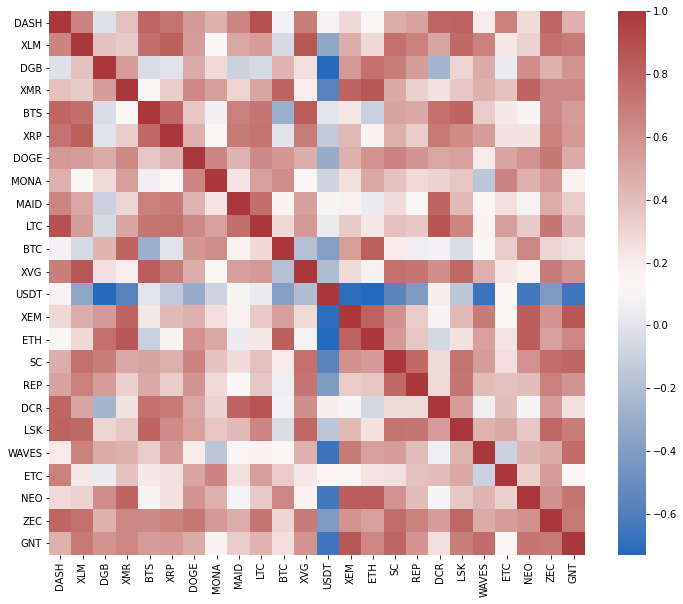

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cierres.corr(), cmap="vlag", ax=ax);

In [17]:
resultados, pares_aptos, score_matrix, pvalue_matrix = find_cointegrated_pairs(
    cierres)

p-value


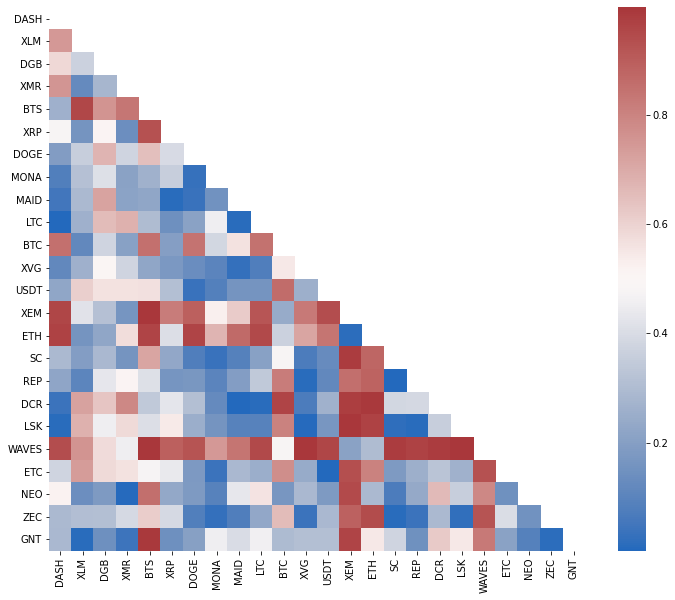

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
print("p-value")
sns.heatmap(pvalue_matrix, cmap="vlag", ax=ax);

Test Statistic


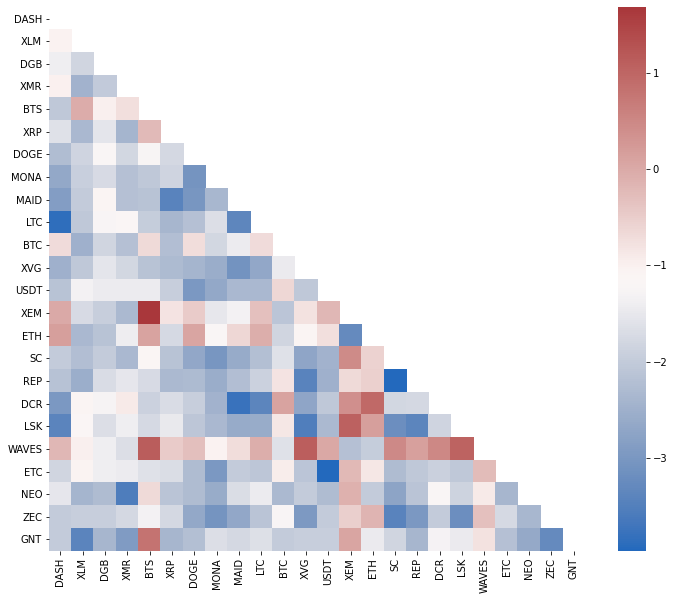

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))
print("Test Statistic")
sns.heatmap(score_matrix, cmap="vlag", ax=ax);

In [22]:
pares_aptos

,,Test Statistic,p-value,#Lags Usados,Número de Observaciones,Valor Critico (1%),Valor Critico (5%),Valor Critico (10%)
SC,REP,-3.965576,0.001602,8.0,688.0,-3.439891,-2.865750,-2.569012
USDT,ETC,-3.952711,0.001679,15.0,681.0,-3.439989,-2.865793,-2.569035
DASH,LTC,-3.855843,0.002385,1.0,695.0,-3.439794,-2.865708,-2.568989
MAID,DCR,-3.782338,0.003093,3.0,693.0,-3.439821,-2.865720,-2.568996
XMR,NEO,-3.557225,0.006633,16.0,680.0,-3.440003,-2.865800,-2.569038
XVG,LSK,-3.536991,0.007086,0.0,696.0,-3.439780,-2.865702,-2.568986


In [113]:
n = 0
seleccionados = list(pares_aptos.sort_values("p-value").index[n])
seleccionados 
#SiaCoin y Augur

['SC', 'REP']

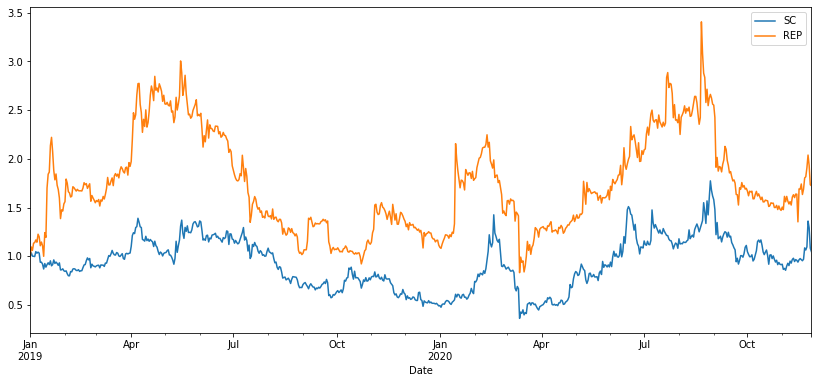

In [114]:
#Representamos las dos gráficas
cierres[seleccionados].div(cierres[seleccionados].iloc[0]).plot();

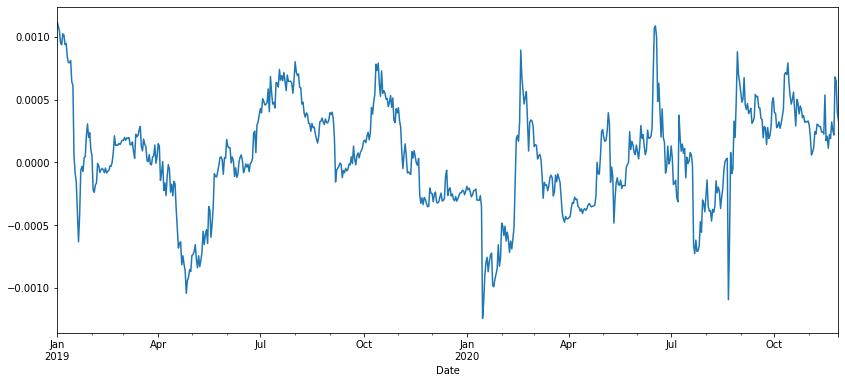

In [115]:
# Representamos los residuos entre los valores y nuestra regresion
regresion = ols(cierres[seleccionados[0]], cierres[seleccionados[1]])
regresion.resid.plot()

In [116]:
cierres[seleccionados].corr()

,SC,REP
SC,1.000000,0.777533
REP,0.777533,1.000000


In [117]:
# R-Cuadrado para verificar que el modelo explica
regresion.rsquared

0.9675067112917436

Regresión


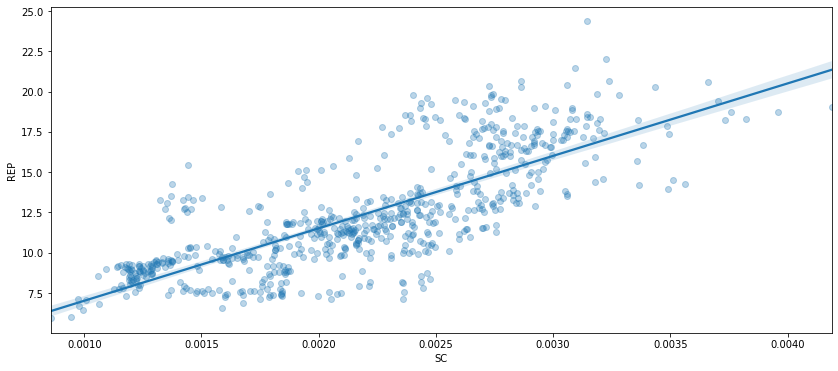

In [118]:
print("Regresión")
sns.regplot(*seleccionados, cierres, scatter_kws={'alpha': 0.3});

In [ ]:
#Implementacion estrategia

In [119]:
spread = cierres[seleccionados[1]] - cierres[seleccionados[0]]

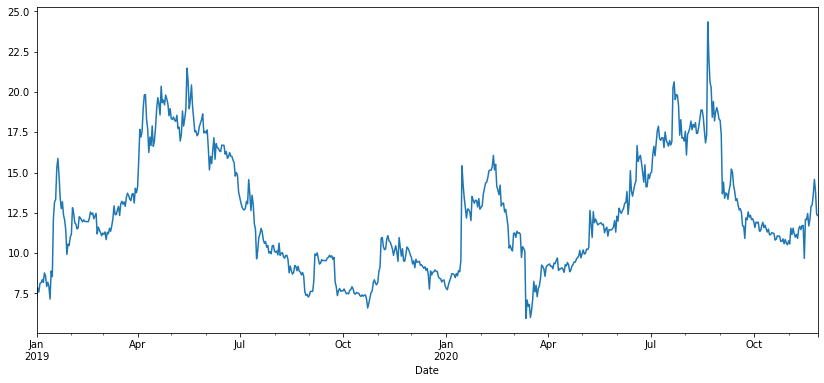

In [120]:
spread.plot();

In [121]:
#Z-Score para estandarizar
def zscore(data):
    return data.sub(data.mean())/data.std()

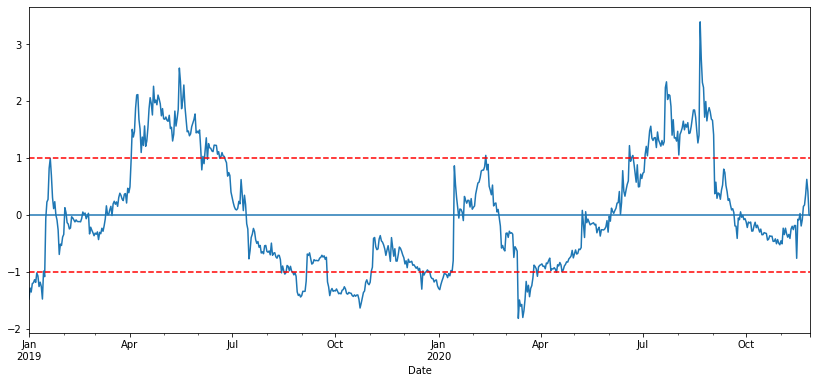

In [122]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean())
plt.axhline(1, c='r', ls='--')
plt.axhline(-1, c='r', ls='--');

In [123]:
window = int(apply_half_life(spread))
window

29

In [124]:
spread_mean_window  = spread.rolling(window).mean()
spread_std_window  = spread.rolling(window).std()

In [125]:
zscore_window = spread.sub(spread_mean_window)/spread_std_window

In [126]:
#Calculo señales
trigger_up = zscore_window[zscore_window.gt(0)].quantile(.9) 
trigger_down = zscore_window[zscore_window.lt(0)].quantile(.1)
trigger_up, trigger_down

(2.230398767883125, -1.9798470992805783)

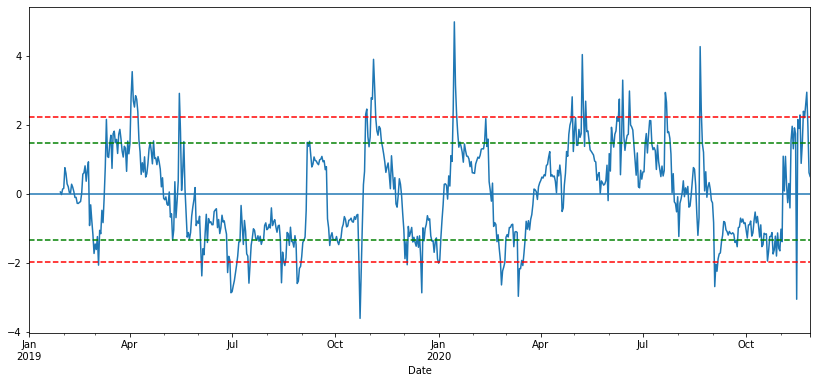

In [127]:
#spread.div(spread.iloc[0]).sub(1).plot(c='g')
zscore_window.plot()
plt.axhline(0)
plt.axhline(trigger_up, c='r', ls='--')
plt.axhline(trigger_up/1.5, c='g', ls='--')
plt.axhline(trigger_down, c='r', ls='--');
plt.axhline(trigger_down/1.5, c='g', ls='--');

In [128]:
data = cierres[seleccionados]

In [129]:
data['spread'] = spread
data['pct_change'] = spread.pct_change()

In [130]:
data['zscore'] = zscore_window

In [131]:
# Estrategia

data['signal']=0
for i in range(1,data.shape[0]-1): 
    
    #Abrir posicion de venta
    if data['zscore'].iloc[i-1] >= trigger_up and data['zscore'].iloc[i] < trigger_up:
        data['signal'].iloc[i] = -1
        
    #Abrir posicion de compra
    elif data['zscore'].iloc[i-1] <= trigger_down and data['zscore'].iloc[i] > trigger_down:
        data['signal'].iloc[i] = 1
        
    #Cerrar posición de venta 
    elif data['signal'].iloc[i-1] == -1 and data['zscore'].iloc[i] < trigger_up/1.5: 
        data['signal'].iloc[i]=0 
        
    #Cerrar posicion de compra
    elif data['signal'].iloc[i-1] == 1 and data['zscore'].iloc[i] > trigger_down/1.5: 
        data['signal'].iloc[i]=0 
        
    else: 
        data['signal'].iloc[i]= data['signal'].iloc[i-1]

In [132]:
data['returns'] = data['pct_change'].mul(data['signal'].shift())
data['equity'] = data['returns'].fillna(0).add(1).cumprod()

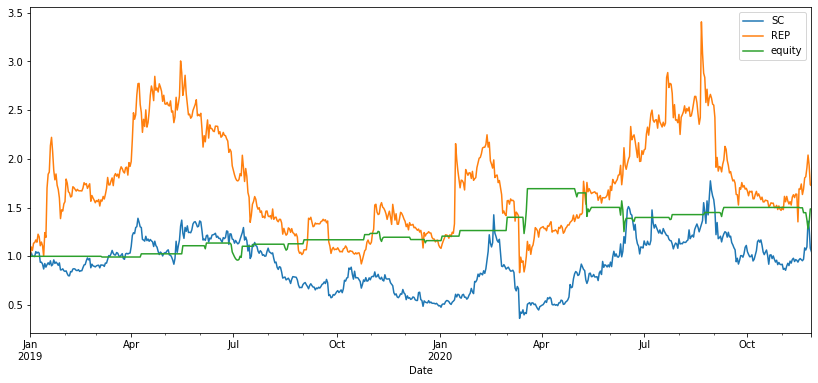

In [133]:
data[seleccionados].div(data[seleccionados].iloc[0]).plot(legend=True)
data['equity'].plot(legend=True);

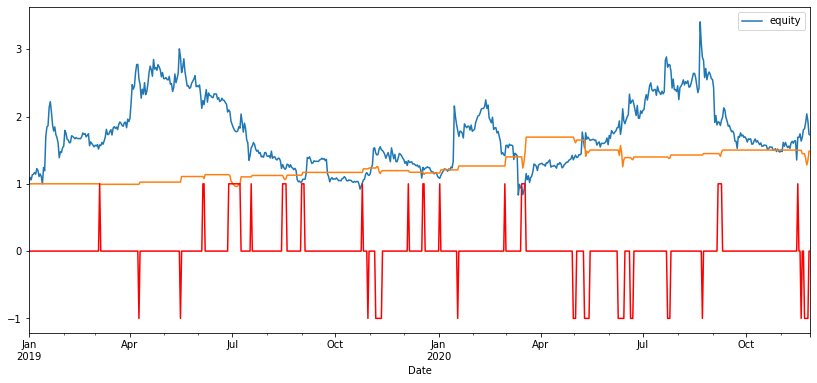

In [134]:
ax=spread.div(spread.iloc[0]).plot()
data['equity'].plot(legend=True);
data['signal'].plot(ax=ax, color='r');

In [ ]:
data['equity'].tail()